In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%tensorflow_version 1.x
!pip install tensorflow-gpu==1.14.0

TensorFlow 1.x selected.
  Using cached https://files.pythonhosted.org/packages/3c/d5/21860a5b11caf0678fbc8319341b0ae21a07156911132e0e71bffed0510d/tensorflow_estimator-1.14.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/91/2d/2ed263449a078cd9c8a9ba50ebd50123adf1f8cfbea1492f9084169b89d9/tensorboard-1.14.0-py3-none-any.whl
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 1.15.2 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow 1.15.2 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.14.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninst

In [3]:
!pip install bert-tensorflow

In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from datetime import datetime
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
print(tf.__version__)

1.15.2


In [112]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [113]:
!ls /content/drive/My\ Drive/logically_test

main.py   NLP_data_scientist_test  output_dir	  __pycache__
model.py  nlp_test.ipynb	   preprocess.py


In [0]:
df = pd.read_excel('/content/drive/My Drive/logically_test/NLP_data_scientist_test/data/Entity_sentiment_trainV2.xlsx')

In [0]:
# EDA

In [116]:
df.head()

,Sentence,Entity,Sentiment
0,The website was very easy to use and my insura...,website,positive
1,The web sight was easy to understand and I got...,web sight,positive
2,Having filled in the application on-line I cou...,point,negative
3,After finding AXA was cheaper than my renewal ...,prices,positive
4,The quote was a reasonable price compared with...,insurances,positive


In [117]:
len(df)

5999

In [118]:
df.isnull().sum()

Sentence     0
Entity       0
Sentiment    0
dtype: int64

In [0]:
# Description of the dataset

In [120]:
df.describe()

,Sentence,Entity,Sentiment
count,5999,5999,5999
unique,5649,748,2
top,A little fiddly answering some of the question...,service,positive
freq,2,705,4100


In [121]:
df1 = df.groupby('Sentiment').count()['Sentence'].reset_index().sort_values(by='Sentence',ascending=False)
df1.style.background_gradient(cmap='Purples')

,Sentiment,Sentence
1,positive,4100
0,negative,1899


In [0]:
# Visualising the labels

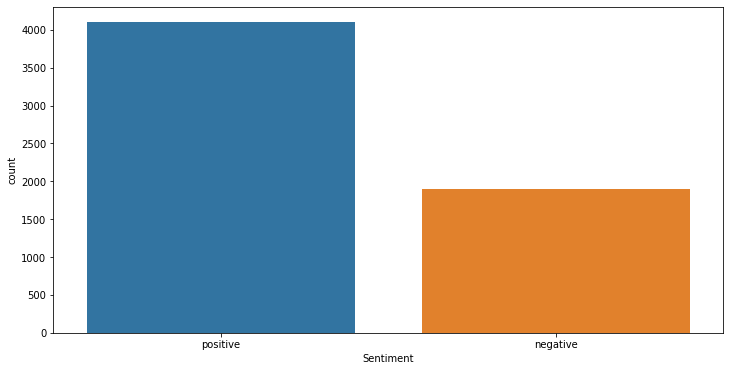

In [123]:
plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment',data=df)

In [0]:
# creating input examples

In [0]:
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['Sentiment'])
df['entity_label'] = encoder.fit_transform(df['Entity'])
mask = np.random.rand(len(df)) < 0.7 #spliting 70% of data for training and 30% for testing 

train = df[mask]
test = df[~mask]

DATA_COLUMN = 'Sentence'
ENTITY_COLUMN = 'entity_label'
LABEL_COLUMN = 'label'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0,1]

# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)


In [0]:
# Loading BERT

In [0]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)


In [0]:
# tokenizing

In [183]:
tokenizer = create_tokenizer_from_hub_module()

# We'll set sequences to be at most 32 tokens long.
MAX_SEQ_LENGTH = 32

# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Writing example 0 of 4156


INFO:tensorflow:Writing example 0 of 4156


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the website was very easy to use and my insurance was up and running within a few minutes . . . quick simple brilliant [SEP]


INFO:tensorflow:tokens: [CLS] the website was very easy to use and my insurance was up and running within a few minutes . . . quick simple brilliant [SEP]


INFO:tensorflow:input_ids: 101 1996 4037 2001 2200 3733 2000 2224 1998 2026 5427 2001 2039 1998 2770 2306 1037 2261 2781 1012 1012 1012 4248 3722 8235 102 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 4037 2001 2200 3733 2000 2224 1998 2026 5427 2001 2039 1998 2770 2306 1037 2261 2781 1012 1012 1012 4248 3722 8235 102 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the web sight was easy to understand and i got the cover i wanted and need [SEP]


INFO:tensorflow:tokens: [CLS] the web sight was easy to understand and i got the cover i wanted and need [SEP]


INFO:tensorflow:input_ids: 101 1996 4773 4356 2001 3733 2000 3305 1998 1045 2288 1996 3104 1045 2359 1998 2342 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 4773 4356 2001 3733 2000 3305 1998 1045 2288 1996 3104 1045 2359 1998 2342 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] after finding ax ##a was cheaper than my renewal i instantly went to their website to see the offers and prices they were offering . [SEP]


INFO:tensorflow:tokens: [CLS] after finding ax ##a was cheaper than my renewal i instantly went to their website to see the offers and prices they were offering . [SEP]


INFO:tensorflow:input_ids: 101 2044 4531 22260 2050 2001 16269 2084 2026 14524 1045 6880 2253 2000 2037 4037 2000 2156 1996 4107 1998 7597 2027 2020 5378 1012 102 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2044 4531 22260 2050 2001 16269 2084 2026 14524 1045 6880 2253 2000 2037 4037 2000 2156 1996 4107 1998 7597 2027 2020 5378 1012 102 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] easy to use fair price don ' t like auto renewal though . [SEP]


INFO:tensorflow:tokens: [CLS] easy to use fair price don ' t like auto renewal though . [SEP]


INFO:tensorflow:input_ids: 101 3733 2000 2224 4189 3976 2123 1005 1056 2066 8285 14524 2295 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3733 2000 2224 4189 3976 2123 1005 1056 2066 8285 14524 2295 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] exhaust ##ive as expected but as i had a company car ( claim free ) for eight years i feel i should have been able to use this towards no [SEP]


INFO:tensorflow:tokens: [CLS] exhaust ##ive as expected but as i had a company car ( claim free ) for eight years i feel i should have been able to use this towards no [SEP]


INFO:tensorflow:input_ids: 101 15095 3512 2004 3517 2021 2004 1045 2018 1037 2194 2482 1006 4366 2489 1007 2005 2809 2086 1045 2514 1045 2323 2031 2042 2583 2000 2224 2023 2875 2053 102


INFO:tensorflow:input_ids: 101 15095 3512 2004 3517 2021 2004 1045 2018 1037 2194 2482 1006 4366 2489 1007 2005 2809 2086 1045 2514 1045 2323 2031 2042 2583 2000 2224 2023 2875 2053 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 0 of 1843


INFO:tensorflow:Writing example 0 of 1843


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] having filled in the application on - line i could not see the point of answering all the questions again on the phone . [SEP]


INFO:tensorflow:tokens: [CLS] having filled in the application on - line i could not see the point of answering all the questions again on the phone . [SEP]


INFO:tensorflow:input_ids: 101 2383 3561 1999 1996 4646 2006 1011 2240 1045 2071 2025 2156 1996 2391 1997 10739 2035 1996 3980 2153 2006 1996 3042 1012 102 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2383 3561 1999 1996 4646 2006 1011 2240 1045 2071 2025 2156 1996 2391 1997 10739 2035 1996 3980 2153 2006 1996 3042 1012 102 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the quote was a reasonable price compared with other insurance ##s . [SEP]


INFO:tensorflow:tokens: [CLS] the quote was a reasonable price compared with other insurance ##s . [SEP]


INFO:tensorflow:input_ids: 101 1996 14686 2001 1037 9608 3976 4102 2007 2060 5427 2015 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1996 14686 2001 1037 9608 3976 4102 2007 2060 5427 2015 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] excellent price for insurance and good fast service from professional staff [SEP]


INFO:tensorflow:tokens: [CLS] excellent price for insurance and good fast service from professional staff [SEP]


INFO:tensorflow:input_ids: 101 6581 3976 2005 5427 1998 2204 3435 2326 2013 2658 3095 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6581 3976 2005 5427 1998 2204 3435 2326 2013 2658 3095 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] web site very user friendly the cost of the insurance was extremely competitive with many optional add on ##s [SEP]


INFO:tensorflow:tokens: [CLS] web site very user friendly the cost of the insurance was extremely competitive with many optional add on ##s [SEP]


INFO:tensorflow:input_ids: 101 4773 2609 2200 5310 5379 1996 3465 1997 1996 5427 2001 5186 6975 2007 2116 11887 5587 2006 2015 102 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4773 2609 2200 5310 5379 1996 3465 1997 1996 5427 2001 5186 6975 2007 2116 11887 5587 2006 2015 102 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] simple straightforward easy to follow for people like myself who are not well verse ##d in modern technology [SEP]


INFO:tensorflow:tokens: [CLS] simple straightforward easy to follow for people like myself who are not well verse ##d in modern technology [SEP]


INFO:tensorflow:input_ids: 101 3722 19647 3733 2000 3582 2005 2111 2066 2870 2040 2024 2025 2092 7893 2094 1999 2715 2974 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3722 19647 3733 2000 3582 2005 2111 2066 2870 2040 2024 2025 2092 7893 2094 1999 2715 2974 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


In [0]:
# create_model

In [0]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)




In [0]:
# Model function

In [0]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [0]:

# Assigning Output Directory

In [189]:
OUTPUT_DIR = '/content/drive/My Drive/logically_test/NLP_data_scientist_test/OUTPUT_DIR'#@param {type:"string"}
#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}
#@markdown Set USE_BUCKET and BUCKET if you want to (optionally) store model output on GCP bucket.
USE_BUCKET = False #@param {type:"boolean"}
BUCKET = None #@param {type:"string"}

if USE_BUCKET:
  OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, OUTPUT_DIR)
  from google.colab import auth
  auth.authenticate_user()

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    # Doesn't matter if the directory didn't exist
    pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /content/drive/My Drive/logically_test/NLP_data_scientist_test/OUTPUT_DIR *****


In [198]:
# Compute train and warmup steps from batch size
MAX_SEQ_LENGTH = 32
BATCH_SIZE = 50
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 4
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 252

# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir= OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})



INFO:tensorflow:Using config: {'_model_dir': '/content/drive/My Drive/logically_test/NLP_data_scientist_test/OUTPUT_DIR', '_tf_random_seed': None, '_save_summary_steps': 252, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd799936160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/drive/My Drive/logically_test/NLP_data_scientist_test/OUTPUT_DIR', '_tf_random_seed': None, '_save_summary_steps': 252, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd799936160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [199]:
num_train_steps

332

In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [202]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


Training took time  0:00:00.100105


In [0]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)




In [204]:
performance_stats = estimator.evaluate(input_fn=test_input_fn, steps=None)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-04-10T13:06:48Z


INFO:tensorflow:Starting evaluation at 2020-04-10T13:06:48Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/logically_test/NLP_data_scientist_test/OUTPUT_DIR/model.ckpt-498


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/logically_test/NLP_data_scientist_test/OUTPUT_DIR/model.ckpt-498


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-04-10-13:07:04


INFO:tensorflow:Finished evaluation at 2020-04-10-13:07:04


INFO:tensorflow:Saving dict for global step 498: auc = 0.8978103, eval_accuracy = 0.9169832, f1_score = 0.93950176, false_negatives = 60.0, false_positives = 93.0, global_step = 498, loss = 0.42379126, precision = 0.92740047, recall = 0.9519231, true_negatives = 502.0, true_positives = 1188.0


INFO:tensorflow:Saving dict for global step 498: auc = 0.8978103, eval_accuracy = 0.9169832, f1_score = 0.93950176, false_negatives = 60.0, false_positives = 93.0, global_step = 498, loss = 0.42379126, precision = 0.92740047, recall = 0.9519231, true_negatives = 502.0, true_positives = 1188.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 498: /content/drive/My Drive/logically_test/NLP_data_scientist_test/OUTPUT_DIR/model.ckpt-498


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 498: /content/drive/My Drive/logically_test/NLP_data_scientist_test/OUTPUT_DIR/model.ckpt-498


In [205]:
performance_stats

{'auc': 0.8978103,
 'eval_accuracy': 0.9169832,
 'f1_score': 0.93950176,
 'false_negatives': 60.0,
 'false_positives': 93.0,
 'global_step': 498,
 'loss': 0.42379126,
 'precision': 0.92740047,
 'recall': 0.9519231,
 'true_negatives': 502.0,
 'true_positives': 1188.0}

In [0]:
# load from checkpoints

In [0]:
def getPrediction(in_sentences,entity):
      labels = ["Negative", "Positive"]
      input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = entity, label = 0) for x in in_sentences] # here, "" is just a dummy label
      input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
      predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
      predictions = estimator.predict(predict_input_fn)
      return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]


In [0]:
"""
# Sentence + Entity

for epochs = 3, batch_size = 50
{'auc': 0.891482,
 'eval_accuracy': 0.9155405,
 'f1_score': 0.93971056,
 'false_negatives': 55.0,
 'false_positives': 95.0,
 'global_step': 253,
 'loss': 0.299825,
 'precision': 0.92484176,
 'recall': 0.95506537,
 'true_negatives': 457.0,
 'true_positives': 1169.0}

for epochs = 4, batch_size = 50

{'auc': 0.89823097,
 'eval_accuracy': 0.920045,
 'f1_score': 0.94278806,
 'false_negatives': 54.0,
 'false_positives': 88.0,
 'global_step': 337,
 'loss': 0.31358176,
 'precision': 0.9300477,
 'recall': 0.9558824,
 'true_negatives': 464.0,
 'true_positives': 1170.0}

for epochs = 5, batch_size = 50

{'auc': 0.89519393,
 'eval_accuracy': 0.9172297,
 'f1_score': 0.9407496,
 'false_negatives': 57.0,
 'false_positives': 90.0,
 'global_step': 422,
 'loss': 0.3330881,
 'precision': 0.92840093,
 'recall': 0.95343137,
 'true_negatives': 462.0,
 'true_positives': 1167.0}

# Only Sentence
for epoch = 4, batch_size = 50

{'auc': 0.8978103,
 'eval_accuracy': 0.9169832,
 'f1_score': 0.93950176,
 'false_negatives': 60.0,
 'false_positives': 93.0,
 'global_step': 498,
 'loss': 0.42379126,
 'precision': 0.92740047,
 'recall': 0.9519231,
 'true_negatives': 502.0,
 'true_positives': 1188.0}

In [0]:
# getPrediction('they just removed the itunes credit reward with zero communication','reward')

In [0]:
# f1_score without entity feature: 0.94038683
# final f-1 score: 0.93854743 with sent+entity